In [1]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import stats
import json
import os
from mpl_toolkits.mplot3d import Axes3D
from entropy import *
import entropy

## Importing data from Data_Jsons

Se genera un dataframe con todos los datos válidos de todas las bases de datos

In [2]:
data = list()
for data_file in os.listdir("./Data_Jsons"):
    with open("./Data_Jsons/"+data_file) as file:
        mixed = json.load(file)
        appr = [reg for reg in mixed if reg["approved"]]
        data.extend(appr)
        print(f"{data_file} has {len(appr)}/{len(mixed)} approved cases")
data = pd.DataFrame(data)
data["rr"] = data.apply(lambda case: np.array(case["rr"])/case["fs"], axis=1)
data["rr"] = data["rr"].apply(lambda signal: signal[np.where(signal < 2)])
data["length"] = data["rr"].apply(lambda signal: len(signal))

afdb-1.0.0.physionet.org.json has 22/25 approved cases
chfdb-1.0.0.physionet.org.json has 15/15 approved cases
ltafdb-1.0.0.physionet.org.json has 52/52 approved cases
mitdb-1.0.0.physionet.org.json has 48/48 approved cases
nn-cases-healthy-control.json has 17/17 approved cases
normal-sinus-rhythm-rr-interval-database-1.0.0.json has 54/54 approved cases
ptbdb-1.0.0.physionet.org.json has 59/59 approved cases


In [3]:
num_cases = 15
AF_CASES = data[(data["conditon"] == "AF") & (data["length"] > 1000)][:num_cases]  # AF - Atrial Fibrilation
CHF_CASES = data[(data["conditon"] == "CHF") & (data["length"] > 1000)][:num_cases]  # CHF - Congestive Heart Failure
HC_CASES = data[(data["conditon"] == "HC") & (data["length"] > 1000)][:num_cases]  # HC - Healthy Controls
AR_CASES = data[(data["conditon"] == "AR") & (data["length"] > 1000)][:num_cases]  # AR - Arrhythmia Cases - NO HAY CASOS QUE CUMPLAN 
MI_CASES = data[(data["conditon"] == "MI") & (data["length"] > 1000)][:num_cases]  # MI - Myocardial Infarction - NO HAY CASOS QUE CUMPLAN
print(f"\nAF CASES:{len(AF_CASES)}\nCHF CASES:{len(CHF_CASES)}\nHC CASES:{len(HC_CASES)}\nAR CASES:{len(AR_CASES)}\nMI CASES:{len(MI_CASES)}")


AF CASES:15
CHF CASES:14
HC CASES:15
AR CASES:15
MI CASES:0


In [4]:
m = 0
for k in [4, 6, 4]:
    v = np.arange(k) + m
    print(v)
    m = np.max(v) + 1

[0 1 2 3]
[4 5 6 7 8 9]
[10 11 12 13]


### Bases con Momentos agregados

In [4]:
from TT_utilities import add_moments, add_nonlinear

AF_CASES = AF_CASES.apply(add_moments, axis=1)
CHF_CASES = CHF_CASES.apply(add_moments, axis=1)
HC_CASES = HC_CASES.apply(add_moments, axis=1)

AF_CASES = AF_CASES.apply(add_nonlinear, axis=1)
CHF_CASES = CHF_CASES.apply(add_nonlinear, axis=1)
HC_CASES = HC_CASES.apply(add_nonlinear, axis=1)

In [5]:
print(" - ".join(AF_CASES.columns))
print(" - ".join(CHF_CASES.columns))
print(" - ".join(HC_CASES.columns))

database - record - rr - comments - fs - approved - conditon - length - M1 - M2 - M3 - M4 - CV - AppEn - SampEn - HFD - DFA - SD_ratio
database - record - rr - comments - fs - approved - conditon - length - M1 - M2 - M3 - M4 - CV - AppEn - SampEn - HFD - DFA - SD_ratio
database - record - rr - comments - fs - approved - conditon - length - M1 - M2 - M3 - M4 - CV - AppEn - SampEn - HFD - DFA - SD_ratio


KeyError: 0

AttributeError: module 'matplotlib.pyplot' has no attribute 'patches'

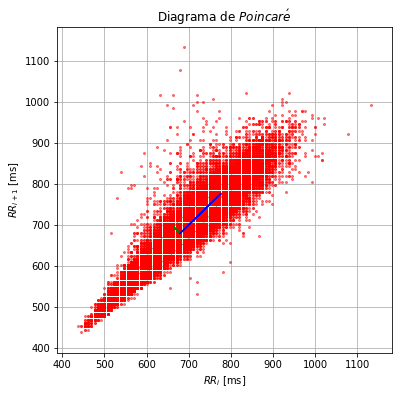

In [10]:
# POINCARE
from TT_utilities import poincarePlot

HC_CASES = HC_CASES.reset_index()
poincarePlot(HC_CASES["rr"][0],show=True,ellipse=True,vectors=True,legend=True)


## Plotting RR Moments

In [ ]:
## Ploteo por grupos:
titles = ["Fibrilación Atrial", "Insuficiencia Cardíaca Congestiva", "Casos Saludables"]
for cases, title in zip([AF_CASES, CHF_CASES, HC_CASES], titles):
    figure, axs = plt.subplots(5, 1, figsize=(12, 15))
    figure.suptitle(title, y=1.01)

    for i in range(len(cases)):
    
        axs[0].set_title("1º Momento - Media")
        axs[0].plot(cases.iloc[i]["M1"])
        axs[0].autoscale(enable=True, axis='x', tight=True)
        
        axs[1].set_title("2º Momento - Varianza")
        axs[1].plot(cases.iloc[i]["M2"])
        axs[1].autoscale(enable=True, axis='x', tight=True)
        
        axs[2].set_title("3º Momento - Sesgo")
        axs[2].plot(cases.iloc[i]["M3"])
        axs[2].autoscale(enable=True, axis='x', tight=True)
        
        axs[3].set_title("4º Momento - Curtosis")
        axs[3].plot(cases.iloc[i]["M4"])
        axs[3].autoscale(enable=True, axis='x', tight=True)
        
        axs[4].set_title("Coeficiente de Variación")
        axs[4].plot(cases.iloc[i]["CV"])
        axs[4].autoscale(enable=True, axis='x', tight=True)
        
    axs[-1].set_xlabel("No. de Ventana")
    plt.tight_layout()
    plt.show()

In [ ]:
def get_max(DF, col):
    return np.max([np.max(DF[col][i]) for i in DF.index if len(DF[col][i]) > 0])

def get_min(DF, col):
    return np.min([np.min(DF[col][i]) for i in DF.index if len(DF[col][i]) > 0])

In [ ]:
## Ploteo por técnica:
conditions = ["Fibrilación Atrial", "Insuficiencia Cardíaca Congestiva", "Casos Saludables"]
techniques = ["Entropía aproximada", "Entropía muestral", "Analisis de Fluctuación sin Tendencia (DFA)", "Coeficiente de Higuchi (HFD)"]
columns = ["AppEn", "SampEn", "DFA", "HFD"]
cases = [AF_CASES, CHF_CASES, HC_CASES]

for idx, title, col in zip([1, 2, 3, 4], techniques, columns):
    figure, axs = plt.subplots(3, 1, figsize=(8, 10))
    figure.suptitle(title, y=1.01)
    
    top = np.max([get_max(c, col) for c in cases])
    bot = np.min([get_min(c, col) for c in cases])
    
    axs[0].set_title(conditions[0])
    for i in range(len(cases[0])):
        axs[0].plot(cases[0].iloc[i][col])
    axs[0].autoscale(enable=True, axis='x', tight=True)
    axs[0].set_ylim(bottom=bot, top=top)

    axs[1].set_title(conditions[1])
    for i in range(len(cases[1])):
        axs[1].plot(cases[1].iloc[i][col])
    axs[1].autoscale(enable=True, axis='x', tight=True)
    axs[1].set_ylim(bottom=bot, top=top)

    axs[2].set_title(conditions[2])
    for i in range(len(cases[2])):
        axs[2].plot(cases[2].iloc[i][col])
    axs[2].autoscale(enable=True, axis='x', tight=True)
    axs[2].set_ylim(bottom=bot, top=top)

    axs[-1].set_xlabel(f"Figura {idx}")
    plt.tight_layout()
    plt.show()

In [ ]:
## Ploteo por grupos:
titles = ["Fibrilación Atrial", "Insuficiencia Cardíaca Congestiva", "Casos Saludables"]
for cases, title in zip([AF_CASES, CHF_CASES, HC_CASES], titles):
    figure, axs = plt.subplots(3, 1, figsize=(12, 8))
    figure.suptitle(title, y=1.01)
    for i in range(len(cases)):
        axs[0].set_title("Entropía aproximada")
        axs[0].plot(cases.iloc[i]["AppEn"])
        axs[0].autoscale(enable=True, axis='x', tight=True)
        axs[0].set_ylim(bottom=0, top=2)
        
        axs[1].set_title("Entropía muestral")
        axs[1].plot(cases.iloc[i]["SampEn"])
        axs[1].autoscale(enable=True, axis='x', tight=True)
        axs[1].set_ylim(bottom=0, top=3)
        
        axs[2].set_title("DFA")
        axs[2].plot(cases.iloc[i]["DFA"])
        axs[2].autoscale(enable=True, axis='x', tight=True)
        axs[2].set_ylim(bottom=0, top=1.5)
    axs[-1].set_xlabel("No. de Ventana")
    plt.tight_layout()
    plt.show()

 figure2, axs2 = plt.subplots(3, 1, figsize=(12, 15))
    figure2.suptitle(title, y=1.01)
    for i in range(len(cases)):
        axs[0].set_title("Entropía aproximada")
        axs[0].plot(cases.iloc[i]["AppEn"])
        axs[0].autoscale(enable=True, axis='x', tight=True)
        axs[0].set_ylim(bottom=0, top=3)
        
        axs[1].set_title("Entropía muestral")
        axs[1].plot(cases.iloc[i]["SampEn"])
        axs[1].autoscale(enable=True, axis='x', tight=True)
        axs[1].set_ylim(bottom=0, top=3)
        
        axs[2].set_title("DFA")
        axs[2].plot(cases.iloc[i]["DFA"])
        axs[2].autoscale(enable=True, axis='x', tight=True)
        axs[2].set_ylim(bottom=0, top=3)
    axs2[-1].set_xlabel("No. de Ventana")

In [ ]:
case = AF_CASES.iloc[2]

RR = case["rr"]
#x_time = np.cumsum(RR)

fig1, axs1 = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
gs = axs1[2, 1].get_gridspec()
axs1[0, 0].remove()

Window = 1000
overlap = 0.95
means, var, skew, kurt = RR_Windowing(RR, Window, overlap)

labels = [(i+i+Window)/2 for i in range(0, len(RR)-Window, int(Window*(1-overlap)))]

# plot time signal (healthy):
record = case['record']
title = "Señal RR:  Registro "+record +" (Fibrillacion Atrial)"
axbig = fig1.add_subplot(gs[0, :])
axbig.set_title(title)
axbig.plot(RR, color='C0')
axbig.set_xlabel("Nò. Interlatido")
axbig.set_ylabel("R-R(segundos)")
    
    
# plot moments:
axs1[1, 0].set_title("Media (Primer Momento)")
axs1[1, 0].plot(labels, means,color='C1')
axs1[1, 0].set_xlabel("Nò. Interlatido")

axs1[1, 1].set_title("Varianza (Segundo Momento)")
axs1[1, 1].plot(labels, var, color='red')
axs1[1, 1].set_xlabel("Nò. Interlatido")

axs1[2, 0].set_title("Sesgo (Tercer Momento)")
axs1[2, 0].plot(labels, skew, color='C2')
axs1[2, 0].set_xlabel("Nò. Interlatido")

axs1[2, 1].set_title("Curtosis (Cuarto Momento)")
axs1[2, 1].plot(labels, kurt, color='cyan')
axs1[2, 1].set_xlabel("No. Interlatido")

axs1[0, 1].remove()
fig1.tight_layout()
plt.show()

## Windowing using Itertools 

In [ ]:
import itertools  

print(np.array(case['rr']))
# initializing list  
RR = np.array(case['rr'])
print ("Length of RR signal: ", end ="") 
print(len(RR))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
x=np.arange(len(RR))
print(len(x))

# using islice() to slice the list acc. to need  
# starts printing from 2nd index till 6th skipping 2  
print ("The original vector is: ", end ="") 

print ("The sliced list values are : ", end ="")  
wsize = 100
step = 1
x1=np.arange(wsize)

#for i in range(len(li)-(wsize-1)):
    #print (list(itertools.islice(RR1, i, i+wsize, step)))
    
axs[0].plot(x,RR,color='blue')
axs[1].plot(x1,list(itertools.islice(RR, 1, 1+wsize, step)),color='red')
fig.show()
    

In [ ]:
def RR_Windowing(rr_signal, w_len, over, mode="sample"):
    """
    rr_signal :: RR vector of time in seconds
    w_time    :: Defines window time in seconds
    over      :: Defines overlapping between windows
    l_thresh  :: Gets lower threshold of window
    mode      :: Sets mode of windowing;
                    "sample" - Same sized windows, iterates by sample count.
                    "time" - Variable sized windows, iterates over time window.

    """
    means, var, skew, kurt = list(), list(), list(), list()
    step = int(w_len*(1-over))
    
    if mode == "time":
        time_vec = np.cumsum(rr_signal)
        l_thresh = time_vec[0]
        while l_thresh < max(time_vec)-w_len:
            window = np.where(np.bitwise_and((l_thresh < time_vec), (time_vec < (l_thresh+w_len))))
            rr_window = RR[window]
            
            ds = stats.describe(rr_window)
            means.append(ds[2])
            var.append(ds[3])
            skew.append(ds[4])
            kurt.append(ds[5])
    
            l_thresh += step

    elif mode == "sample":
        for rr_window in [rr_signal[i:i+w_len] for i in range(0, len(rr_signal)-w_len, step)]:
            ds = stats.describe(rr_window)
            means.append(ds[2])
            var.append(ds[3])
            skew.append(ds[4])
            kurt.append(ds[5])
    
    return means, var, skew, kurt

def add_points(row, mo_config=m_config):
    ds = stats.describe(row["rr"])
    row["mean"] = ds[2]
    row["var"] = ds[3]
    row["skew"] = ds[4]
    row["kurt"] = ds[5]
    return row[["record", "conditon", "mean", "var", "skew", "kurt"]]

m_config = {"window": 1000, "overlap": 0.95}
def add_moments(row, mo_config=m_config):
    means, var, skew, kurt = RR_Windowing(row.rr, m_config["window"], m_config["overlap"])
    row["M1"] = means
    row["M2"] = var
    row["M3"] = skew
    row["M4"] = kurt
    row["CV"] = np.divide(var, means)
    return row[["record", "conditon", ""]]

def get_one_stats(data, condition, moment):
    SERIES = list()
    for record in data[data["conditon"] == "AF"]["record"].unique():
        CASE = data[(data["record"] == record) & (data["length"] > 5000)]
        if CASE is None:
            continue
            
        SERIES.append(CASE[moment].apply(pd.Series).stack().describe().to_frame(name=record))
    return pd.concat(SERIES, axis=1).round(5)

In [ ]:
def add_points(row, mo_config=m_config):
    ds = stats.describe(row["rr"])
    row["mean"] = ds[2]
    row["var"] = ds[3]
    row["skew"] = ds[4]
    row["kurt"] = ds[5]
    return row[["record", "conditon", "mean", "var", "skew", "kurt"]]
SCATER_DATA = data[data["length"] > 5000].apply(add_points, axis=1)

In [ ]:
MAf=list(SCATER_DATA[SCATER_DATA["conditon"]=="AF"]["mean"])
VAf=list(SCATER_DATA[SCATER_DATA["conditon"]=="AF"]["var"])
SAf=list(SCATER_DATA[SCATER_DATA["conditon"]=="AF"]["skew"])

MCHF=list(SCATER_DATA[SCATER_DATA["conditon"]=="CHF"]["mean"])
VCHF=list(SCATER_DATA[SCATER_DATA["conditon"]=="CHF"]["var"])
SCHF=list(SCATER_DATA[SCATER_DATA["conditon"]=="CHF"]["skew"])

MHC=list(SCATER_DATA[SCATER_DATA["conditon"]=="HC"]["mean"])
VHC=list(SCATER_DATA[SCATER_DATA["conditon"]=="HC"]["var"])
SVHC=list(SCATER_DATA[SCATER_DATA["conditon"]=="HC"]["skew"])

#colors=("red", "green", "blue")
#fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

#for color in colors:
    #ax.scatter(MAf, VAf, SAf,c=color)

plt.scatter(VAf, SAf, s=None, c='red', marker=".", cmap=None, norm=None, vmin=None, vmax=None, alpha=None,label="FA")
plt.scatter(VCHF, SCHF, s=None, c='green', marker="v", cmap=None, norm=None, vmin=None, vmax=None, alpha=None,label="ICC")
plt.scatter(VHC, SVHC, s=None, c='blue', marker="x", cmap=None, norm=None, vmin=None, vmax=None, alpha=None,label="Sano")

plt.xlabel("Varianza")
plt.ylabel("Sesgo")


plt.legend()



## Función de Mapa de Poincaré

In [ ]:
fs = 125

In [ ]:
60/220

In [ ]:
type(slice(2, 3))

In [ ]:
slice(2)